In [32]:
from __future__ import division, print_function, absolute_import
import urllib2
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

In [33]:
def download_dataset(url, file_name, directory='data/fashion'):
    
    print("Download", file_name)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    response = urllib2.urlopen(url)
    file_content = response.read()
    with open(os.path.join(directory, file_name), 'wb') as f:
        f.write(file_content)

In [34]:
download_dataset('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
                'train-images-idx3-ubyte.gz')
download_dataset('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
                'train-labels-idx1-ubyte.gz')
download_dataset('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
                't10k-images-idx3-ubyte.gz')
download_dataset('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
                't10k-labels-idx1-ubyte.gz')

Download train-images-idx3-ubyte.gz
Download train-labels-idx1-ubyte.gz
Download t10k-images-idx3-ubyte.gz
Download t10k-labels-idx1-ubyte.gz


In [35]:
mnist = input_data.read_data_sets("data/fashion")

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [36]:
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

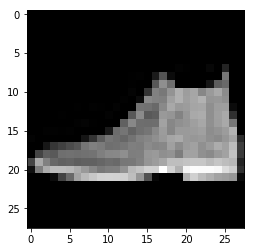

Ankle boot


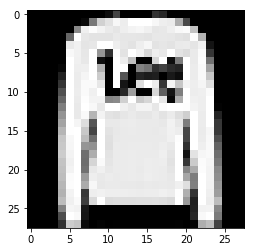

Pullover


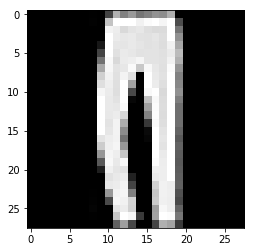

Trouser


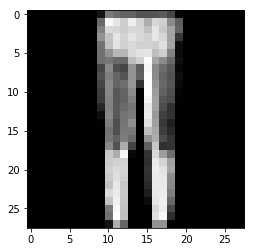

Trouser


In [37]:
# Check data
n_images = 4
test_images = mnist.test.images[:n_images]
test_labels = mnist.test.labels[:n_images]

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print(labels[test_labels[i]])

In [38]:
learning_rate = 0.001
num_steps = 2000
batch_size = 256

num_input = 784
num_classes = 10
dropout = 0.8

In [39]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = x_dict['images']
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        
        fc1 = tf.contrib.layers.flatten(conv2)
        fc1 = tf.layers.dense(fc1, 1024)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        
        out = tf.layers.dense(fc1, n_classes)
        
    return out

In [40]:
def model_fn(features, labels, mode):
    
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probs = tf.nn.softmax(logits_test)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_opt = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    acc_opt = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss,
      train_op=train_opt,
      eval_metric_ops={'accuracy': acc_opt})
    
    return estim_specs

In [41]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': '/tmp/tmpoYnOMx', '_save_summary_steps': 100}


In [42]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpoYnOMx/model.ckpt.
INFO:tensorflow:loss = 2.3348, step = 1
INFO:tensorflow:global_step/sec: 3.7923
INFO:tensorflow:loss = 0.454822, step = 101 (26.369 sec)
INFO:tensorflow:global_step/sec: 3.80278
INFO:tensorflow:loss = 0.437409, step = 201 (26.296 sec)
INFO:tensorflow:global_step/sec: 3.75542
INFO:tensorflow:loss = 0.384797, step = 301 (26.628 sec)
INFO:tensorflow:global_step/sec: 3.64992
INFO:tensorflow:loss = 0.302987, step = 401 (27.398 sec)
INFO:tensorflow:global_step/sec: 3.14461
INFO:tensorflow:loss = 0.325911, step = 501 (31.800 sec)
INFO:tensorflow:global_step/sec: 3.75049
INFO:tensorflow:loss = 0.255001, step = 601 (26.663 sec)
INFO:tensorflow:global_step/sec: 3.80007
INFO:tensorflow:loss = 0.313694, step = 701 (26.315 sec)
INFO:tensorflow:global_step/sec: 3.78168
INFO:tensorflow:loss = 0.383825, step = 801 (26.443 sec)
INFO:tensorflow:global_step/sec: 3.7942
INFO:tensorflow:loss

In [43]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)

model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2017-09-30-20:01:17
INFO:tensorflow:Restoring parameters from /tmp/tmpoYnOMx/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-09-30-20:01:21
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9038, global_step = 2000, loss = 0.287097


{'accuracy': 0.90380001, 'global_step': 2000, 'loss': 0.28709731}

INFO:tensorflow:Restoring parameters from /tmp/tmpoYnOMx/model.ckpt-2000


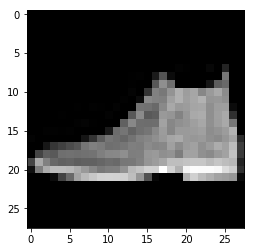

Actual:  Ankle boot
Prediction: Ankle boot


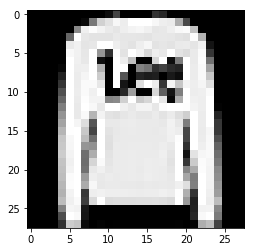

Actual:  Pullover
Prediction: Pullover


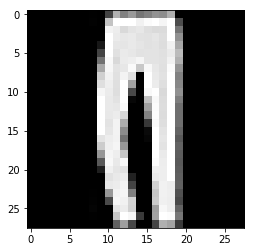

Actual:  Trouser
Prediction: Trouser


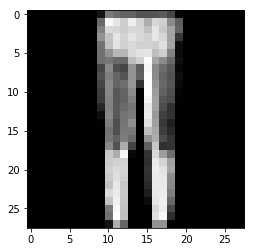

Actual:  Trouser
Prediction: Trouser


In [44]:
n_images = 4
test_images = mnist.test.images[:n_images]
test_labels = mnist.test.labels[:n_images]

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)

preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Actual: ", labels[test_labels[i]])
    print("Prediction:", labels[preds[i]])